<a href="https://colab.research.google.com/github/dede0702/Assistente-Virtual-RAG-para-Desastres/blob/main/Classifica%C3%A7%C3%A3o_de_Desastres_com_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
0. Install kagglehub, Download Dataset, and Locate Original Data Root
```



In [ ]:
# This block handles dataset download and finding the base path of the dataset.
!pip install kagglehub -q

import kagglehub
import os
import shutil # For copying files
import zipfile # Though kagglehub usually handles unzipping

print("Downloading dataset via kagglehub...")
# This downloads to a path like /root/.cache/kagglehub/datasets/varpit94/disaster-images-dataset/
download_path = kagglehub.dataset_download("varpit94/disaster-images-dataset")
print(f"Dataset downloaded to: {download_path}")

Dataset downloaded to: /kaggle/input/disaster-images-dataset


In [ ]:
# The actual image data is typically within a folder named "Comprehensive Disaster Images Dataset"
# which might itself be nested if the zip had a top-level folder.
original_dataset_base_path = None

# Potential paths to the "Comprehensive Disaster Images Dataset" folder
path_option1 = os.path.join(download_path, "Comprehensive Disaster Images Dataset")
# Sometimes Kaggle zips include an extra top-level directory with the same name
path_option2 = os.path.join(download_path, "Comprehensive Disaster Images Dataset", "Comprehensive Disaster Images Dataset")

In [ ]:
# Check for a known subfolder like "Damaged_Infrastructure" to confirm the correct base path
if os.path.isdir(path_option1) and os.path.isdir(os.path.join(path_option1, "Damaged_Infrastructure")):
    original_dataset_base_path = path_option1
elif os.path.isdir(path_option2) and os.path.isdir(os.path.join(path_option2, "Damaged_Infrastructure")):
    original_dataset_base_path = path_option2
else:
    # Fallback: try to find it by walking
    print("Standard paths not found, attempting to search...")
    for root, dirs, files in os.walk(download_path):
        if "Comprehensive Disaster Images Dataset" in dirs:
            # Check if this "Comprehensive Disaster Images Dataset" contains the actual data folders
            test_path = os.path.join(root, "Comprehensive Disaster Images Dataset")
            if os.path.isdir(os.path.join(test_path, "Damaged_Infrastructure")):
                 original_dataset_base_path = test_path
                 break
        # If the current root itself contains the data folders (e.g. if download_path was already inside "Comprehensive ...")
        elif "Damaged_Infrastructure" in dirs and "Fire_Disaster" in dirs:
            original_dataset_base_path = root # This root is the parent of Damaged_Infrastructure etc.
            break


if original_dataset_base_path and os.path.exists(original_dataset_base_path):
    print(f"Located original dataset base at: {original_dataset_base_path}")
else:
    print(f"Error: Could not locate the 'Comprehensive Disaster Images Dataset' root directory within {download_path}.")
    print("Please manually inspect the downloaded structure and set 'original_dataset_base_path'.")
    print("Listing contents of download_path:")
    if os.path.exists(download_path):
        for item in os.listdir(download_path):
            print(os.path.join(download_path, item))
    original_dataset_base_path = None # Ensure it's None if not found

Standard paths not found, attempting to search...
Located original dataset base at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)




```
0.5. Reorganize Data into a Flat Structure for ImageDataGenerator
```



In [ ]:
flat_data_dir = "flat_disaster_images" # New directory for flattened data
source_to_target_map = {} # To store {new_class_name: original_path_to_images}
data_dir_for_generators = None # Initialize

In [ ]:
flat_data_dir = "flat_disaster_images" # New directory for flattened data
source_to_target_map = {} # To store {new_class_name: original_path_to_images}
data_dir_for_generators = None # Initialize

if original_dataset_base_path:
    print(f"Original dataset base path is: {original_dataset_base_path}")

    # Define the mapping from original nested structure to new flat class names
    # Based on Kaggle dataset page structure and common usage
    potential_classes_sources = {
        "Earthquake": os.path.join(original_dataset_base_path, "Damaged_Infrastructure", "Earthquake"),
        "Infrastructure_Damage": os.path.join(original_dataset_base_path, "Damaged_Infrastructure", "Infrastructure"),
        "Urban_Fire": os.path.join(original_dataset_base_path, "Fire_Disaster", "Urban_Fire"),
        "Wild_Fire": os.path.join(original_dataset_base_path, "Fire_Disaster", "Wild_Fire"),
        "Human_Damage": os.path.join(original_dataset_base_path, "Human_Damage"),
        "Drought": os.path.join(original_dataset_base_path, "Land_Disaster", "Drought"),
        "Land_Slide": os.path.join(original_dataset_base_path, "Land_Disaster", "Land_Slide"),
        "Non_Damage_Building": os.path.join(original_dataset_base_path, "Non_Damage", "Non_Damage_Building"),
        "Non_Damage_Wildlife": os.path.join(original_dataset_base_path, "Non_Damage", "Non_Damage_Wildlife"),
        "human_non_damage": os.path.join(original_dataset_base_path, "Non_Damage", "human"),
        "sea_non_damage": os.path.join(original_dataset_base_path, "Non_Damage", "sea"),
        "Cyclone": os.path.join(original_dataset_base_path, "Water_Disaster", "Cyclone"),
        "Flood": os.path.join(original_dataset_base_path, "Water__Disaster", "Flood"), # Typo in "Water_ Disaster" often seen
        "Tsunami": os.path.join(original_dataset_base_path, "Water_Disaster", "Tsunami"),
    }
    # Add alternative path for Flood due to potential typo
    flood_alt_path = os.path.join(original_dataset_base_path, "Water_Disaster", "Flood")


    # Validate paths and create the final source_to_target_map
    for class_name, source_path in potential_classes_sources.items():
        current_source_path = source_path
        if class_name == "Flood" and not os.path.isdir(source_path) and os.path.isdir(flood_alt_path):
            print(f"Using alternative path for Flood: {flood_alt_path}")
            current_source_path = flood_alt_path

        if os.path.isdir(current_source_path):
            source_to_target_map[class_name] = current_source_path
            print(f"Found source for class '{class_name}': {current_source_path}")
        else:
            print(f"Warning: Source path for class '{class_name}' not found or is not a directory: {current_source_path}")

    if not source_to_target_map:
        print("Error: No valid source class paths found. Data reorganization cannot proceed.")
    else:
        if os.path.exists(flat_data_dir):
            print(f"Removing existing flat directory: {flat_data_dir}")
            shutil.rmtree(flat_data_dir)
        os.makedirs(flat_data_dir, exist_ok=True)
        print(f"Created new flat directory: {flat_data_dir}")

        valid_image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp')
        total_images_copied = 0

        print("\nCopying images to flat structure...")
        for class_name, original_class_path in source_to_target_map.items():
            target_class_path = os.path.join(flat_data_dir, class_name)
            os.makedirs(target_class_path, exist_ok=True)

            images_in_class = 0
            try:
                for item_name in os.listdir(original_class_path):
                    if item_name.lower().endswith(valid_image_extensions) and not item_name.startswith("._"): # Skip macOS metadata files
                        source_item_path = os.path.join(original_class_path, item_name)
                        target_item_path = os.path.join(target_class_path, item_name)
                        shutil.copy2(source_item_path, target_item_path)
                        images_in_class += 1
                print(f"  Copied {images_in_class} images for class '{class_name}' to '{target_class_path}'")
                total_images_copied += images_in_class
            except FileNotFoundError:
                print(f"Error: Original class path '{original_class_path}' for class '{class_name}' not found during image listing.")
            except Exception as e:
                print(f"An error occurred while copying for class '{class_name}': {e}")

        print(f"\nTotal images copied: {total_images_copied}")
        if total_images_copied == 0:
            print("Error: No images were copied. Check original paths, image extensions, and permissions.")
        else:
            data_dir_for_generators = flat_data_dir
            print(f"Data reorganization complete. New data directory for generators: {data_dir_for_generators}")
else:
    print("Error: 'original_dataset_base_path' was not set. Cannot proceed with data reorganization.")

Original dataset base path is: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)
Found source for class 'Earthquake': /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Damaged_Infrastructure/Earthquake
Found source for class 'Infrastructure_Damage': /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Damaged_Infrastructure/Infrastructure
Found source for class 'Urban_Fire': /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Fire_Disaster/Urban_Fire
Found source for class 'Wild_Fire': /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Fire_Disaster/Wild_Fire
Found source for class 'Human_Damage': /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage
Found source for class 'Drought': /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Land_Disaster/Drought
Found source for class 'Land_Slide': /kaggle/input/disaster-imag



```
 0.6. Validate and Clean Images
```



In [ ]:
from PIL import Image, UnidentifiedImageError
import os # Ensure os is imported if not already in this cell

if data_dir_for_generators and os.path.exists(data_dir_for_generators):
    print(f"\nValidating images in: {data_dir_for_generators}")
    removed_count = 0
    # Use os.walk to iterate through all subdirectories
    for root, _, files in os.walk(data_dir_for_generators):
        for image_file in files:
            image_path = os.path.join(root, image_file)
            # Check for common image file extensions
            if image_file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp')):
                try:
                    # Check for zero-byte files first
                    if os.path.getsize(image_path) == 0:
                        print(f"Removing zero-byte file: {image_path}")
                        os.remove(image_path)
                        removed_count += 1
                        continue # Skip to next file

                    # Try to open the image with PIL's error handling
                    # Using Image.open() with a try-except block is standard for validation
                    img = Image.open(image_path)
                    # img.verify() # Optional: shallow check, sometimes not sufficient
                    img.load() # More thorough check for file integrity
                    img.close() # Close file handle
                except (UnidentifiedImageError, SyntaxError, IOError, OSError) as e: # Catch common PIL errors and OSError
                    print(f"Removing problematic image '{image_path}': {e}")
                    os.remove(image_path)
                    removed_count += 1
                except Exception as e: # Catch any other unexpected error during loading/verification
                    print(f"Unexpected error processing '{image_path}', removing: {e}")
                    os.remove(image_path)
                    removed_count +=1
    print(f"Image validation complete. Removed {removed_count} problematic images.")
else:
    print("Skipping image validation: 'data_dir_for_generators' not set or does not exist.")


Validating images in: flat_disaster_images
Removing problematic image 'flat_disaster_images/Infrastructure_Damage/05_01_0261.png': image file is truncated (0 bytes not processed)
Removing problematic image 'flat_disaster_images/Human_Damage/02_0069.png': cannot identify image file 'flat_disaster_images/Human_Damage/02_0069.png'
Image validation complete. Removed 2 problematic images.




```
1. Setup and Imports
```



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import random

In [ ]:
# This global 'data_dir' will now point to our reorganized flat directory
# It's set in block 0.5 as 'data_dir_for_generators'
data_dir = None # Initialize
CLASS_NAMES = []
NUM_CLASSES = 0

if 'data_dir_for_generators' in globals() and data_dir_for_generators and os.path.exists(data_dir_for_generators):
    data_dir = data_dir_for_generators
    print(f"TensorFlow Version: {tf.__version__}")
    print(f"Using reorganized data directory for images: {data_dir}")

    CLASS_NAMES = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    NUM_CLASSES = len(CLASS_NAMES)
    if NUM_CLASSES > 0:
        print(f"Found {NUM_CLASSES} classes: {CLASS_NAMES}")
    else:
        print(f"Error: No class subdirectories found in the reorganized data directory '{data_dir}'.")
        print("This might be due to issues in data reorganization or cleaning.")
else:
    print("Critical Error: 'data_dir_for_generators' is not set or invalid from the previous block. Please check data reorganization steps.")
    print("Cannot proceed without a valid data directory.")

TensorFlow Version: 2.18.0
Using reorganized data directory for images: flat_disaster_images
Found 9 classes: ['Drought', 'Earthquake', 'Human_Damage', 'Infrastructure_Damage', 'Land_Slide', 'Urban_Fire', 'Wild_Fire', 'human_non_damage', 'sea_non_damage']


In [ ]:
# Global parameters (can be adjusted)
INITIAL_IMG_WIDTH, INITIAL_IMG_HEIGHT = 128, 128
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
SEED = 42 # For reproducibility
USE_CLASS_WEIGHTS = False # Will be updated in EDA

# Etapa 1: Exploração e Entendimento do Dataset (Baseline)



```
1.1. Analise a quantidade de imagens por classe e verifique desbalanceamentos
```




Image counts per class:
- Drought: 201 images
- Earthquake: 36 images
- Human_Damage: 240 images
- Infrastructure_Damage: 1417 images
- Land_Slide: 456 images
- Urban_Fire: 419 images
- Wild_Fire: 514 images
- human_non_damage: 120 images
- sea_non_damage: 2274 images


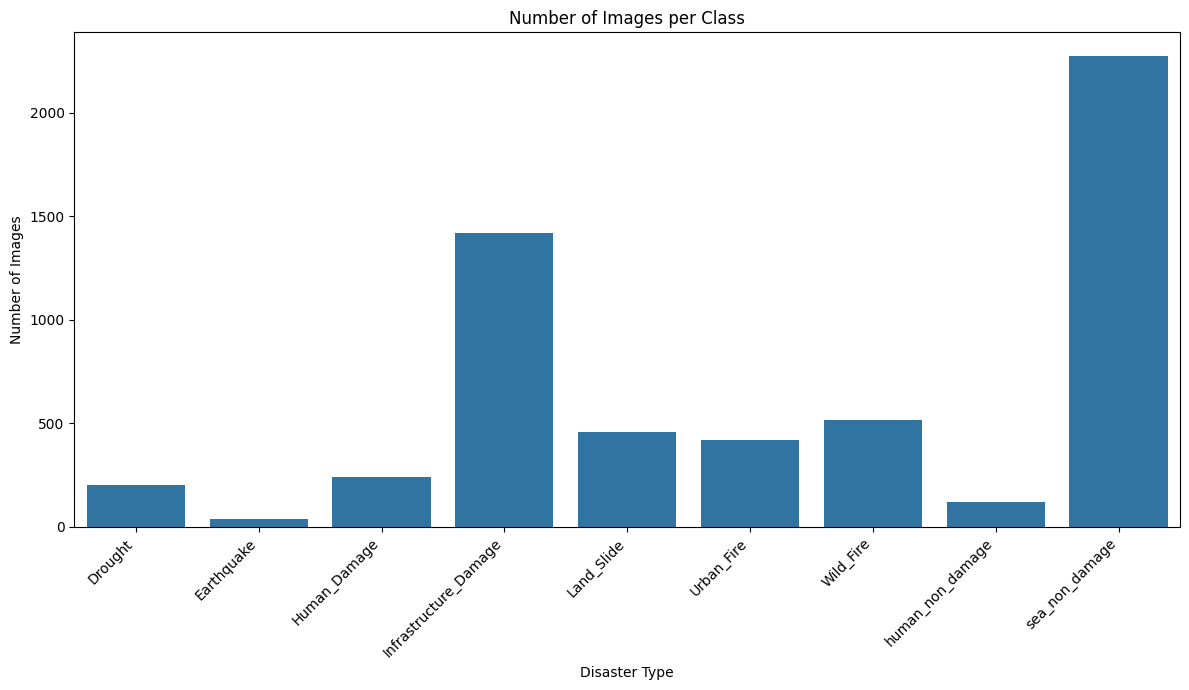


Class Imbalance Ratio (Max/Min, excluding zero-count classes): 63.17


In [ ]:
class_counts = {}
if data_dir and NUM_CLASSES > 0: # Check if data_dir and classes are valid
    print("\nImage counts per class:")
    for class_name in CLASS_NAMES:
        class_path = os.path.join(data_dir, class_name)
        num_images = 0
        if os.path.isdir(class_path): # Ensure it's a directory before listing
            num_images = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
        class_counts[class_name] = num_images
        print(f"- {class_name}: {num_images} images")

    if not class_counts or all(v == 0 for v in class_counts.values()):
        print("Warning: All class counts are zero. Check if images were copied correctly and not all removed during cleaning.")
    else:
        # Plot class distribution
        plt.figure(figsize=(12, 7))
        sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
        plt.title("Number of Images per Class")
        plt.xlabel("Disaster Type")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Check for desbalanceamento
        valid_counts = [v for v in class_counts.values() if v > 0]
        if valid_counts:
            min_count = min(valid_counts)
            max_count = max(valid_counts)
            imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
            print(f"\nClass Imbalance Ratio (Max/Min, excluding zero-count classes): {imbalance_ratio:.2f}")
            if imbalance_ratio > 2.5: # Threshold for significant imbalance
                print("Warning: Significant class imbalance detected. Enabling class weights.")
                USE_CLASS_WEIGHTS = True
            else:
                print("Class distribution is relatively balanced or imbalance is moderate.")
                USE_CLASS_WEIGHTS = False
        else:
            print("Could not calculate class counts meaningfully (all zero or no valid classes).")
            USE_CLASS_WEIGHTS = False
else:
    print("Cannot perform EDA: 'data_dir' not set or no classes found. Check previous blocks.")
    USE_CLASS_WEIGHTS = False



```
1.2. Observe exemplos visuais
```



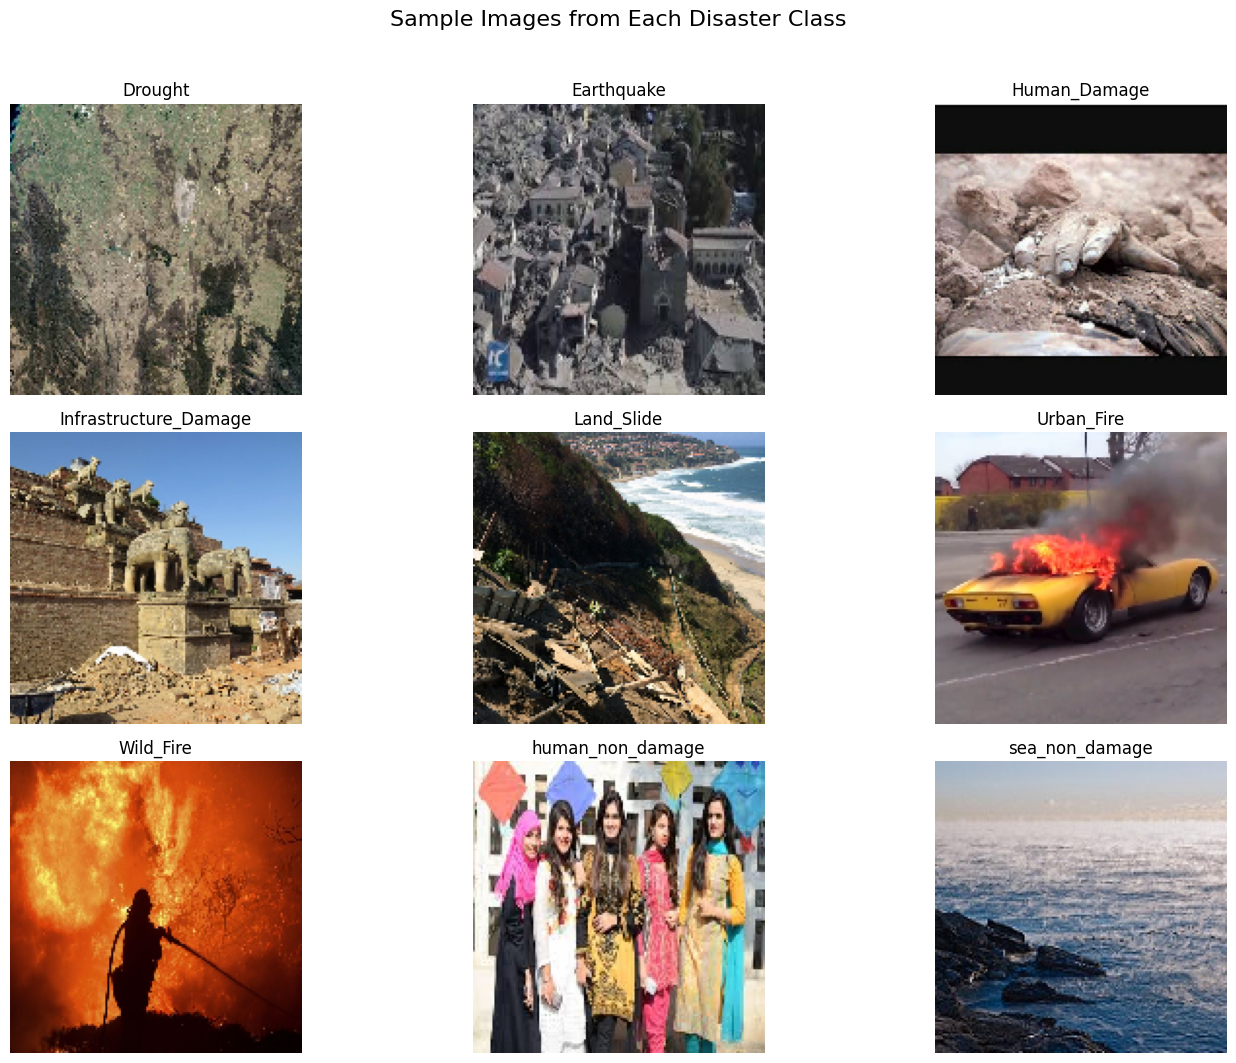

In [ ]:
if data_dir and NUM_CLASSES > 0:
    plt.figure(figsize=(15, max(10, NUM_CLASSES * 1.2))) # Adjust height based on number of classes
    for i, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(data_dir, class_name)

        ax = plt.subplot( (NUM_CLASSES + 2) // 3 , 3, i + 1) # Adjust layout: up to 3 images per row
        plt.title(class_name)
        plt.axis('off')

        if not os.path.isdir(class_path):
            ax.text(0.5, 0.5, f"{class_name}\n(Directory not found)", horizontalalignment='center', verticalalignment='center')
            continue

        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        if not image_files:
            ax.text(0.5, 0.5, f"{class_name}\n(No images found)", horizontalalignment='center', verticalalignment='center')
            continue

        random_image_name = random.choice(image_files)
        img_path = os.path.join(class_path, random_image_name)

        try:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
            plt.imshow(img)
        except Exception as e: # More generic exception for load_img
            print(f"Could not load image {img_path} for class {class_name}: {e}")
            ax.text(0.5, 0.5, f"{class_name}\n(Error loading image)", horizontalalignment='center', verticalalignment='center')

    plt.suptitle("Sample Images from Each Disaster Class", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("Cannot display sample images: 'data_dir' not set or no classes found.")

# Etapa 2 & 3: Modelo CNN Simples (Baseline)



```
2.1. Pré-processamento e Geradores de Dados (Modelo Baseline)
```



In [ ]:
train_generator_base, validation_generator_base = None, None
if data_dir and NUM_CLASSES > 0:
    train_datagen_base = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=VALIDATION_SPLIT
    )

    validation_datagen_base = ImageDataGenerator(
        rescale=1./255,
        validation_split=VALIDATION_SPLIT
    )

    try:
        train_generator_base = train_datagen_base.flow_from_directory(
            data_dir,
            target_size=(INITIAL_IMG_WIDTH, INITIAL_IMG_HEIGHT),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='training',
            shuffle=True,
            seed=SEED
        )

        validation_generator_base = validation_datagen_base.flow_from_directory(
            data_dir,
            target_size=(INITIAL_IMG_WIDTH, INITIAL_IMG_HEIGHT),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='validation',
            shuffle=False,
            seed=SEED
        )

        print(f"Baseline: Found {train_generator_base.samples} images for training, {validation_generator_base.samples} for validation.")
        print(f"Class indices: {train_generator_base.class_indices}")

        if train_generator_base.samples == 0 or validation_generator_base.samples == 0:
            print("Warning: Baseline data generators have 0 samples. Check 'data_dir' and image copying.")
    except Exception as e:
        print(f"Error creating baseline data generators: {e}")
        print("Ensure 'data_dir' points to a directory with class subfolders containing images.")
else:
    print("Cannot create baseline data generators: 'data_dir' not set or no classes found.")

Found 4545 images belonging to 9 classes.
Found 1132 images belonging to 9 classes.
Baseline: Found 4545 images for training, 1132 for validation.
Class indices: {'Drought': 0, 'Earthquake': 1, 'Human_Damage': 2, 'Infrastructure_Damage': 3, 'Land_Slide': 4, 'Urban_Fire': 5, 'Wild_Fire': 6, 'human_non_damage': 7, 'sea_non_damage': 8}




```
3.1. Estrutura do Modelo CNN (Baseline)
```



In [ ]:
model_base = None
if data_dir and NUM_CLASSES > 0 and train_generator_base and train_generator_base.samples > 0:
    model_base = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(INITIAL_IMG_WIDTH, INITIAL_IMG_HEIGHT, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model_base.compile(optimizer=Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
    model_base.summary()
else:
    print("Cannot build baseline model: Conditions not met (check data_dir, NUM_CLASSES, train_generator_base).")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,520,265 (24.87 MB)

 Trainable params: 6,519,305 (24.87 MB)

 Non-trainable params: 960 (3.75 KB)



```
3.2. Treinamento do Modelo CNN (Baseline)
```



In [ ]:
history_base = None
if model_base and train_generator_base and validation_generator_base and train_generator_base.samples > 0 and validation_generator_base.samples > 0:
    EPOCHS_BASE = 30

    early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.00001, verbose=1)

    steps_per_epoch_base = max(1, train_generator_base.samples // BATCH_SIZE)
    validation_steps_base = max(1, validation_generator_base.samples // BATCH_SIZE)

    class_weights_dict_base = None
    if USE_CLASS_WEIGHTS:
        try:
            # Ensure all classes defined by NUM_CLASSES are present in the generator's class indices
            # and that the generator has classes.
            if train_generator_base.classes is not None and len(np.unique(train_generator_base.classes)) > 0:
                class_labels_numeric = np.unique(train_generator_base.classes)
                 # Check if the number of unique classes in the generator matches NUM_CLASSES
                if len(class_labels_numeric) == NUM_CLASSES:
                    class_weights_array = compute_class_weight(
                        'balanced',
                        classes=class_labels_numeric, # these are the actual class indices found by the generator
                        y=train_generator_base.classes
                    )
                    # class_weights_dict_base maps generator's class indices to weights
                    class_weights_dict_base = dict(zip(class_labels_numeric, class_weights_array))
                    print(f"Using class weights for baseline model: {class_weights_dict_base}")
                else:
                    print(f"Warning: Mismatch between NUM_CLASSES ({NUM_CLASSES}) and unique classes in generator ({len(class_labels_numeric)}). Skipping class weights for baseline.")
            else:
                print("Warning: Training generator has no classes or class indices. Skipping class weights for baseline.")
        except Exception as e:
            print(f"Could not compute class weights for baseline model: {e}. Training without them.")

    history_base = model_base.fit(
        train_generator_base,
        epochs=EPOCHS_BASE,
        steps_per_epoch=steps_per_epoch_base,
        validation_data=validation_generator_base,
        validation_steps=validation_steps_base,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weights_dict_base
    )
    print("\nBaseline model training finished.")
else:
    print("Cannot train baseline model: Conditions not met (model, generators, or samples are missing/empty).")

Using class weights for baseline model: {np.int32(0): np.float64(3.1366459627329193), np.int32(1): np.float64(17.413793103448278), np.int32(2): np.float64(2.6302083333333335), np.int32(3): np.float64(0.445326278659612), np.int32(4): np.float64(1.3835616438356164), np.int32(5): np.float64(1.5029761904761905), np.int32(6): np.float64(1.2257281553398058), np.int32(7): np.float64(5.260416666666667), np.int32(8): np.float64(0.2774725274725275)}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 54s 343ms/step - accuracy: 0.3321 - loss: 2.3081 - val_accuracy: 0.3938 - val_loss: 4.2291 - learning_rate: 0.0010
Epoch 2/30
  1/142 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3750 - loss: 2.9261

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.3750 - loss: 2.9261 - val_accuracy: 0.3938 - val_loss: 4.1458 - learning_rate: 0.0010
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 69s 313ms/step - accuracy: 0.4138 - loss: 1.6996 - val_accuracy: 0.4491 - val_loss: 2.6573 - learning_rate: 0.0010
Epoch 4/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.5000 - loss: 2.0307 - val_accuracy: 0.4429 - val_loss: 2.6509 - learning_rate: 0.0010
Epoch 5/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 383ms/step - accuracy: 0.4705 - loss: 1.5253 - val_accuracy: 0.5045 - val_loss: 1.5868 - learning_rate: 0.0010
Epoch 6/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.5938 - loss: 0.9749 - val_accuracy: 0.4938 - val_loss: 1.5977 - learning_rate: 0.0010
Epoch 7/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 423ms/step - accuracy: 0.5255 - loss: 1.3866 - val_accuracy: 0.1920 - val_loss: 3.2678 - learning_rate: 0.0010
Epoch 8/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5312 - loss: 1.5789

# Etapa 4: Avaliação do Modelo (Baseline)



```
4.1. Gráficos de Acurácia e Perda (Baseline)
```



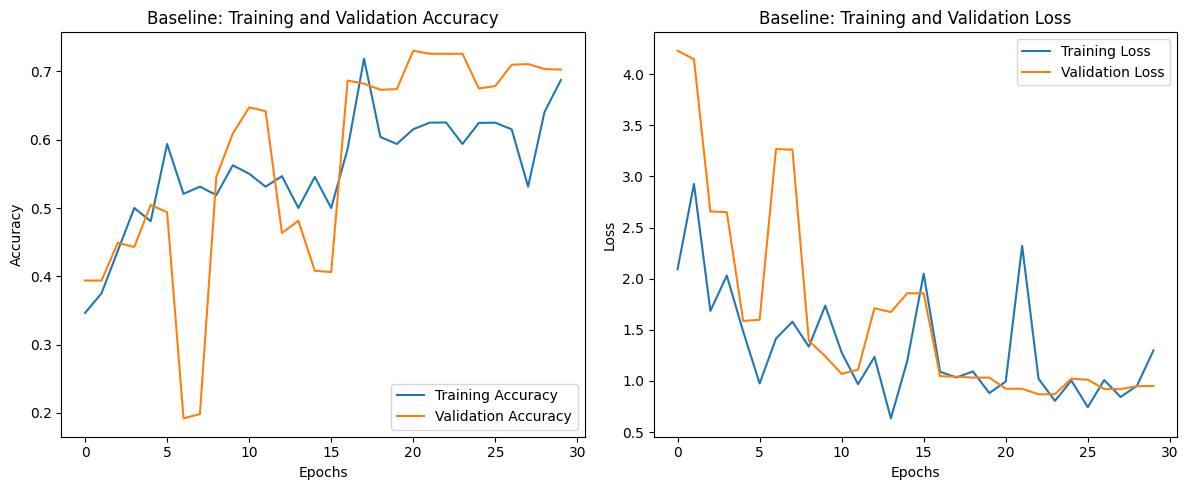

In [ ]:
if history_base:
    acc = history_base.history.get('accuracy')
    val_acc = history_base.history.get('val_accuracy')
    loss = history_base.history.get('loss')
    val_loss = history_base.history.get('val_loss')

    if acc and val_acc and loss and val_loss: # Check if keys exist
        epochs_range = range(len(acc))
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Baseline: Training and Validation Accuracy')
        plt.xlabel('Epochs'); plt.ylabel('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Baseline: Training and Validation Loss')
        plt.xlabel('Epochs'); plt.ylabel('Loss')
        plt.tight_layout(); plt.show()
    else:
        print("Some metrics are missing in baseline history. Cannot plot.")
else:
    print("No training history for baseline model to plot.")



```
4.2. Métricas e Matriz de Confusão (Baseline)
```



Found 1132 images belonging to 9 classes.
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step

Baseline Model - Classification Report:
                       precision    recall  f1-score   support

              Drought       0.41      0.65      0.50        40
           Earthquake       0.09      0.14      0.11         7
         Human_Damage       0.78      0.29      0.42        48
Infrastructure_Damage       0.63      0.89      0.74       283
           Land_Slide       0.56      0.36      0.44        91
           Urban_Fire       0.61      0.34      0.43        83
            Wild_Fire       0.65      0.69      0.67       102
     human_non_damage       0.52      0.58      0.55        24
       sea_non_damage       0.96      0.85      0.90       454

             accuracy                           0.73      1132
            macro avg       0.58      0.53      0.53      1132
         weighted avg       0.75      0.73      0.72      1132


Baseline Model - Confusion Matrix:


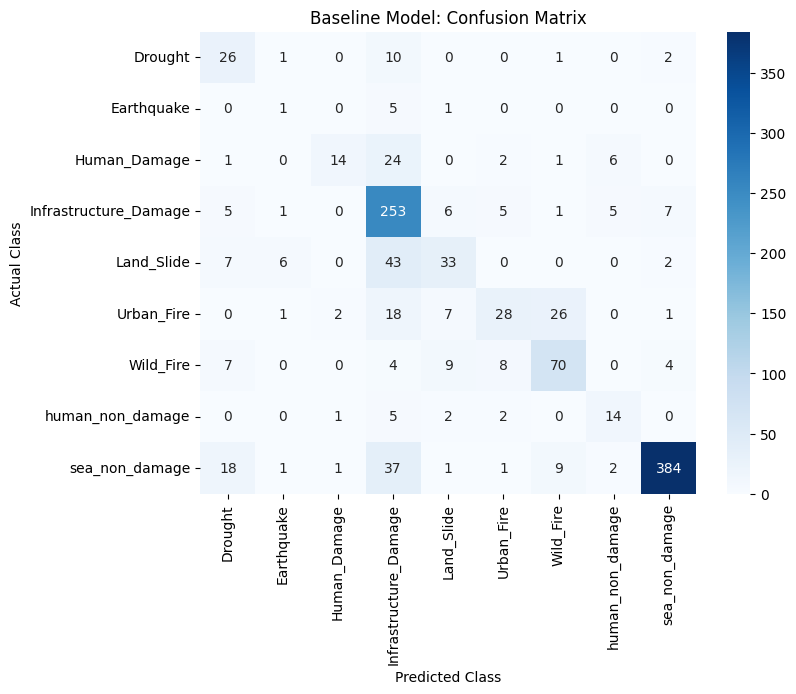

In [ ]:
if model_base and validation_generator_base and validation_generator_base.samples > 0:
    # Recreate for evaluation if necessary, ensuring shuffle=False
    validation_datagen_base_eval = ImageDataGenerator(rescale=1./255, validation_split=VALIDATION_SPLIT)
    try:
        validation_generator_base_eval = validation_datagen_base_eval.flow_from_directory(
            data_dir,
            target_size=(INITIAL_IMG_WIDTH, INITIAL_IMG_HEIGHT),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='validation', # Use the same split
            shuffle=False,      # CRITICAL for evaluation
            seed=SEED
        )

        num_val_samples_base = validation_generator_base_eval.samples
        if num_val_samples_base > 0:
            predict_steps_base = (num_val_samples_base + BATCH_SIZE - 1) // BATCH_SIZE

            Y_pred_probs_base = model_base.predict(validation_generator_base_eval, steps=predict_steps_base, verbose=1)
            Y_pred_classes_base = np.argmax(Y_pred_probs_base, axis=1)
            Y_true_base = validation_generator_base_eval.classes

            Y_pred_classes_base = Y_pred_classes_base[:len(Y_true_base)] # Ensure length match

            if len(Y_true_base) > 0 and len(Y_pred_classes_base) == len(Y_true_base) :
                class_labels_base = list(validation_generator_base_eval.class_indices.keys())

                print("\nBaseline Model - Classification Report:")
                print(classification_report(Y_true_base, Y_pred_classes_base, target_names=class_labels_base, zero_division=0))

                print("\nBaseline Model - Confusion Matrix:")
                cm_base = confusion_matrix(Y_true_base, Y_pred_classes_base, labels=np.arange(NUM_CLASSES)) # ensure all classes shown
                plt.figure(figsize=(max(8, NUM_CLASSES*0.6), max(6, NUM_CLASSES*0.5)))
                sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues',
                            xticklabels=class_labels_base, yticklabels=class_labels_base)
                plt.title('Baseline Model: Confusion Matrix'); plt.ylabel('Actual Class'); plt.xlabel('Predicted Class')
                plt.show()
            else:
                print("Error: Problem with true or predicted labels for baseline model evaluation (length mismatch or empty).")
        else:
            print("No validation samples for baseline model evaluation (eval generator empty).")
    except Exception as e:
        print(f"Error during baseline model evaluation: {e}")
else:
    print("Cannot evaluate baseline model: Conditions not met (model, generator, or samples missing).")

# Etapa 5: Otimização com Transfer Learning (EfficientNetB0)



```
5.0. Setup para Transfer Learning (EfficientNetB0)
```



In [ ]:
TF_IMG_WIDTH, TF_IMG_HEIGHT = 224, 224
TF_BATCH_SIZE = 32

if not (data_dir and NUM_CLASSES > 0):
    print("Critical Error: Cannot proceed with Transfer Learning - data_dir not set or no classes found.")



```
5.1. Geradores de Dados Otimizados (para Transfer Learning)
```



Found 4545 images belonging to 9 classes.
Found 1132 images belonging to 9 classes.
Transfer Learning: Found 4545 training, 1132 validation images.
Class indices: {'Drought': 0, 'Earthquake': 1, 'Human_Damage': 2, 'Infrastructure_Damage': 3, 'Land_Slide': 4, 'Urban_Fire': 5, 'Wild_Fire': 6, 'human_non_damage': 7, 'sea_non_damage': 8}


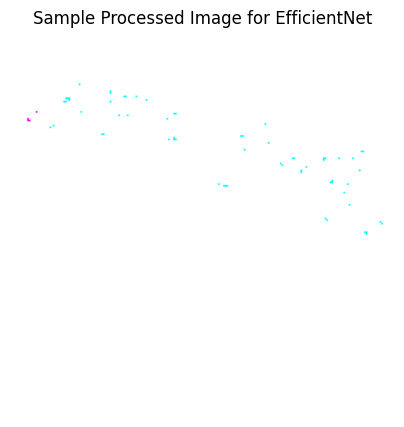

In [ ]:
train_generator_tf, validation_generator_tf = None, None
if data_dir and NUM_CLASSES > 0:
    train_datagen_tf = ImageDataGenerator(
        preprocessing_function=efficientnet_preprocess_input,
        rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.2, zoom_range=0.25, brightness_range=[0.8, 1.2],
        horizontal_flip=True, fill_mode='nearest', validation_split=VALIDATION_SPLIT
    )

    validation_datagen_tf = ImageDataGenerator(
        preprocessing_function=efficientnet_preprocess_input,
        validation_split=VALIDATION_SPLIT
    )
    try:
        train_generator_tf = train_datagen_tf.flow_from_directory(
            data_dir, target_size=(TF_IMG_WIDTH, TF_IMG_HEIGHT), batch_size=TF_BATCH_SIZE,
            class_mode='categorical', subset='training', shuffle=True, seed=SEED
        )

        validation_generator_tf = validation_datagen_tf.flow_from_directory(
            data_dir, target_size=(TF_IMG_WIDTH, TF_IMG_HEIGHT), batch_size=TF_BATCH_SIZE,
            class_mode='categorical', subset='validation', shuffle=False, seed=SEED
        )

        if train_generator_tf.samples > 0 and validation_generator_tf.samples > 0:
            print(f"Transfer Learning: Found {train_generator_tf.samples} training, {validation_generator_tf.samples} validation images.")
            print(f"Class indices: {train_generator_tf.class_indices}")

            if train_generator_tf and train_generator_tf.samples > 0:
                x_batch_tf, y_batch_tf = next(train_generator_tf)
                plt.figure(figsize=(5,5))
                img_to_show = x_batch_tf[0]
                if img_to_show.min() < 0: img_to_show = (img_to_show + 1) / 2.0
                img_to_show = np.clip(img_to_show, 0, 1)
                plt.imshow(img_to_show); plt.title("Sample Processed Image for EfficientNet"); plt.axis('off'); plt.show()
        else:
            print("Warning: Transfer learning data generators have 0 samples.")
            train_generator_tf, validation_generator_tf = None, None # Nullify

    except Exception as e:
        print(f"Error creating Transfer Learning data generators: {e}")
else:
    print("Cannot create Transfer Learning data generators: Conditions not met.")



```
5.2. Construção do Modelo de Transferência (EfficientNetB0 - Feature Extraction)
```



In [ ]:
model_tf, base_model_tf = None, None
if data_dir and NUM_CLASSES > 0 and train_generator_tf and train_generator_tf.samples > 0:
    base_model_tf = EfficientNetB0(
        weights='imagenet', include_top=False,
        input_shape=(TF_IMG_WIDTH, TF_IMG_HEIGHT, 3)
    )
    base_model_tf.trainable = False

    inputs = tf.keras.Input(shape=(TF_IMG_WIDTH, TF_IMG_HEIGHT, 3))
    x = base_model_tf(inputs, training=False) # training=False because BN layers are frozen
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    model_tf = Model(inputs, outputs)

    model_tf.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    model_tf.summary()
else:
    print("Cannot build Transfer Learning model: Conditions not met.")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,712,108 (17.98 MB)

 Trainable params: 661,513 (2.52 MB)

 Non-trainable params: 4,050,595 (15.45 MB)



```
5.3. Treinamento Inicial (Feature Extraction - Transfer Learning)
```



In [ ]:
history_tf_feature_extraction = None
EPOCHS_FEATURE_EXTRACTION = 15

if model_tf and train_generator_tf and validation_generator_tf and train_generator_tf.samples > 0 and validation_generator_tf.samples > 0:
    print(f"\nStarting Transfer Learning (Feature Extraction) for {EPOCHS_FEATURE_EXTRACTION} epochs...")
    early_stopping_tf = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    reduce_lr_tf = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)

    steps_per_epoch_tf = max(1, train_generator_tf.samples // TF_BATCH_SIZE)
    validation_steps_tf = max(1, validation_generator_tf.samples // TF_BATCH_SIZE)

    class_weights_dict_tf = None
    if USE_CLASS_WEIGHTS:
        try:
            if train_generator_tf.classes is not None and len(np.unique(train_generator_tf.classes)) > 0 :
                class_labels_numeric_tf = np.unique(train_generator_tf.classes)
                if len(class_labels_numeric_tf) == NUM_CLASSES:
                    class_weights_array_tf = compute_class_weight('balanced', classes=class_labels_numeric_tf, y=train_generator_tf.classes)
                    class_weights_dict_tf = dict(zip(class_labels_numeric_tf, class_weights_array_tf))
                    print(f"Using class weights for Transfer Learning model: {class_weights_dict_tf}")
                else:
                    print(f"Warning: Mismatch between NUM_CLASSES ({NUM_CLASSES}) and unique classes in TF generator ({len(class_labels_numeric_tf)}). Skipping class weights for TF.")
            else:
                 print("Warning: TF Training generator has no classes or class indices. Skipping class weights for TF.")
        except Exception as e:
            print(f"Could not compute class weights for TF model: {e}. Training without them.")

    history_tf_feature_extraction = model_tf.fit(
        train_generator_tf, epochs=EPOCHS_FEATURE_EXTRACTION,
        steps_per_epoch=steps_per_epoch_tf, validation_data=validation_generator_tf,
        validation_steps=validation_steps_tf, callbacks=[early_stopping_tf, reduce_lr_tf],
        class_weight=class_weights_dict_tf
    )
    print("\nTransfer Learning (Feature Extraction) finished.")
else:
    print("Cannot start Feature Extraction: Conditions not met (model, generators, or samples missing/empty).")


Starting Transfer Learning (Feature Extraction) for 15 epochs...
Using class weights for Transfer Learning model: {np.int32(0): np.float64(3.1366459627329193), np.int32(1): np.float64(17.413793103448278), np.int32(2): np.float64(2.6302083333333335), np.int32(3): np.float64(0.445326278659612), np.int32(4): np.float64(1.3835616438356164), np.int32(5): np.float64(1.5029761904761905), np.int32(6): np.float64(1.2257281553398058), np.int32(7): np.float64(5.260416666666667), np.int32(8): np.float64(0.2774725274725275)}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 117s 683ms/step - accuracy: 0.5746 - loss: 1.5056 - val_accuracy: 0.8652 - val_loss: 0.4209 - learning_rate: 0.0010
Epoch 2/15
  1/142 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6875 - loss: 0.8943

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.6875 - loss: 0.8943 - val_accuracy: 0.8670 - val_loss: 0.4131 - learning_rate: 0.0010
Epoch 3/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 142s 798ms/step - accuracy: 0.7833 - loss: 0.6472 - val_accuracy: 0.8616 - val_loss: 0.4600 - learning_rate: 0.0010
Epoch 4/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7812 - loss: 0.3568 - val_accuracy: 0.8625 - val_loss: 0.4515 - learning_rate: 0.0010
Epoch 5/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8060 - loss: 0.6966 - val_accuracy: 0.9036 - val_loss: 0.3219 - learning_rate: 0.0010
Epoch 6/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8438 - loss: 0.6022 - val_accuracy: 0.9000 - val_loss: 0.3225 - learning_rate: 0.0010
Epoch 7/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 141s 619ms/step - accuracy: 0.8313 - loss: 0.5692 - val_accuracy: 0.8804 - val_loss: 0.3736 - learning_rate: 0.0010
Epoch 8/15
  1/142 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8438 - loss: 0.6778




```
5.4. Configuração para Fine-Tuning (Transfer Learning)
```



In [ ]:
if model_tf and base_model_tf:
    base_model_tf.trainable = True

    # Example: Unfreeze last 20 layers, or a specific block
    # fine_tune_at = -20 # Unfreeze the last 20 layers
    # for layer in base_model_tf.layers[fine_tune_at:]:
    #    layer.trainable = True
    # Defaulting to unfreezing all for simplicity with low LR

    print(f"Number of layers in the base model: {len(base_model_tf.layers)}. All are now trainable for fine-tuning.")

    model_tf.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='categorical_crossentropy', metrics=['accuracy']
    )
    print("\nModel re-compiled for Fine-Tuning.")
    model_tf.summary()
else:
    print("Cannot configure for Fine-Tuning: model_tf or base_model_tf not available.")

Number of layers in the base model: 238. All are now trainable for fine-tuning.

Model re-compiled for Fine-Tuning.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,712,108 (17.98 MB)

 Trainable params: 4,669,061 (17.81 MB)

 Non-trainable params: 43,047 (168.16 KB)



```
 5.5. Treinamento de Fine-Tuning (Transfer Learning)
```



In [ ]:
history_tf_fine_tuning = None
EPOCHS_FINE_TUNING = 20
INITIAL_EPOCH_FINE_TUNING = 0

if model_tf and history_tf_feature_extraction and train_generator_tf and validation_generator_tf and train_generator_tf.samples > 0 and validation_generator_tf.samples > 0:
    # Check if history_tf_feature_extraction.epoch is not None and not empty
    if history_tf_feature_extraction.epoch:
        INITIAL_EPOCH_FINE_TUNING = len(history_tf_feature_extraction.epoch)
    else: # Fallback if epoch list is empty for some reason (e.g. training didn't run)
        INITIAL_EPOCH_FINE_TUNING = EPOCHS_FEATURE_EXTRACTION # Assume previous phase ran full epochs
        print(f"Warning: history_tf_feature_extraction.epoch is empty. Assuming {EPOCHS_FEATURE_EXTRACTION} epochs for feature extraction phase.")


    print(f"\nStarting Transfer Learning (Fine-Tuning) for {EPOCHS_FINE_TUNING} epochs...")
    print(f"Continuing from epoch {INITIAL_EPOCH_FINE_TUNING}")

    early_stopping_ft = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    reduce_lr_ft = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)

    steps_per_epoch_tf = max(1, train_generator_tf.samples // TF_BATCH_SIZE)
    validation_steps_tf = max(1, validation_generator_tf.samples // TF_BATCH_SIZE)

    history_tf_fine_tuning = model_tf.fit(
        train_generator_tf, epochs=INITIAL_EPOCH_FINE_TUNING + EPOCHS_FINE_TUNING,
        initial_epoch=INITIAL_EPOCH_FINE_TUNING,
        steps_per_epoch=steps_per_epoch_tf, validation_data=validation_generator_tf,
        validation_steps=validation_steps_tf, callbacks=[early_stopping_ft, reduce_lr_ft],
        class_weight=class_weights_dict_tf
    )
    print("\nTransfer Learning (Fine-Tuning) finished.")
else:
    print("Cannot start Fine-Tuning: Conditions not met (previous training, model, or generators missing/empty).")


Starting Transfer Learning (Fine-Tuning) for 20 epochs...
Continuing from epoch 10
Epoch 11/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 192s 867ms/step - accuracy: 0.6244 - loss: 1.1562 - val_accuracy: 0.8446 - val_loss: 0.5664 - learning_rate: 1.0000e-05
Epoch 12/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6875 - loss: 1.2914 - val_accuracy: 0.8446 - val_loss: 0.5689 - learning_rate: 1.0000e-05
Epoch 13/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 129s 620ms/step - accuracy: 0.6530 - loss: 1.0145 - val_accuracy: 0.8179 - val_loss: 0.6801 - learning_rate: 1.0000e-05
Epoch 14/30
  1/142 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.6875 - loss: 1.1621
Epoch 14: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.6875 - loss: 1.1621 - val_accuracy: 0.8170 - val_loss: 0.6790 - learning_rate: 1.0000e-05
Epoch 15/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 142s 694ms/step - accuracy: 0.6806 - loss: 0.9334 - val_accuracy: 0.7964 - val_l



```
5.6. Avaliação do Modelo Otimizado (Transfer Learning) - Gráficos e Métricas
```



In [ ]:
if model_tf and validation_generator_tf and validation_generator_tf.samples > 0:
    acc, val_acc, loss, val_loss = [], [], [], []
    start_ft_epoch_line = 0

    if history_tf_feature_extraction:
        acc.extend(history_tf_feature_extraction.history.get('accuracy', []))
        val_acc.extend(history_tf_feature_extraction.history.get('val_accuracy', []))
        loss.extend(history_tf_feature_extraction.history.get('loss', []))
        val_loss.extend(history_tf_feature_extraction.history.get('val_loss', []))
        if history_tf_feature_extraction.epoch:
             start_ft_epoch_line = len(history_tf_feature_extraction.epoch)
        else: # Fallback
            start_ft_epoch_line = EPOCHS_FEATURE_EXTRACTION


    if history_tf_fine_tuning:
        acc.extend(history_tf_fine_tuning.history.get('accuracy', []))
        val_acc.extend(history_tf_fine_tuning.history.get('val_accuracy', []))
        loss.extend(history_tf_fine_tuning.history.get('loss', []))
        val_loss.extend(history_tf_fine_tuning.history.get('val_loss', []))

    if acc:
        epochs_range_tf = range(len(acc))
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range_tf, acc, label='Training Accuracy')
        plt.plot(epochs_range_tf, val_acc, label='Validation Accuracy')
        if history_tf_fine_tuning: plt.axvline(start_ft_epoch_line -1 , linestyle='--', color='r', label='Start Fine-Tuning')
        plt.legend(loc='lower right'); plt.title('TF: Training & Validation Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range_tf, loss, label='Training Loss')
        plt.plot(epochs_range_tf, val_loss, label='Validation Loss')
        if history_tf_fine_tuning: plt.axvline(start_ft_epoch_line -1, linestyle='--', color='r', label='Start Fine-Tuning')
        plt.legend(loc='upper right'); plt.title('TF: Training & Validation Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss')
        plt.tight_layout(); plt.show()
    else:
        print("No combined history to plot for Transfer Learning model.")

    validation_datagen_tf_eval = ImageDataGenerator(preprocessing_function=efficientnet_preprocess_input, validation_split=VALIDATION_SPLIT)
    try:
        validation_generator_tf_eval = validation_datagen_tf_eval.flow_from_directory(
            data_dir, target_size=(TF_IMG_WIDTH, TF_IMG_HEIGHT), batch_size=TF_BATCH_SIZE,
            class_mode='categorical', subset='validation', shuffle=False, seed=SEED
        )

        num_val_samples_tf = validation_generator_tf_eval.samples
        if num_val_samples_tf > 0:
            predict_steps_tf = (num_val_samples_tf + TF_BATCH_SIZE - 1) // TF_BATCH_SIZE

            print("\nEvaluating Transfer Learning Model on Validation Data:")
            Y_pred_probs_tf = model_tf.predict(validation_generator_tf_eval, steps=predict_steps_tf, verbose=1)
            Y_pred_classes_tf = np.argmax(Y_pred_probs_tf, axis=1)
            Y_true_tf = validation_generator_tf_eval.classes
            Y_pred_classes_tf = Y_pred_classes_tf[:len(Y_true_tf)]

            if len(Y_true_tf) > 0 and len(Y_pred_classes_tf) == len(Y_true_tf):
                class_labels_tf = list(validation_generator_tf_eval.class_indices.keys())

                print("\nTransfer Learning Model - Classification Report:")
                print(classification_report(Y_true_tf, Y_pred_classes_tf, target_names=class_labels_tf, zero_division=0))

                print("\nTransfer Learning Model - Confusion Matrix:")
                cm_tf = confusion_matrix(Y_true_tf, Y_pred_classes_tf, labels=np.arange(NUM_CLASSES))
                plt.figure(figsize=(max(8, NUM_CLASSES*0.6), max(6, NUM_CLASSES*0.5)))
                sns.heatmap(cm_tf, annot=True, fmt='d', cmap='viridis',
                            xticklabels=class_labels_tf, yticklabels=class_labels_tf)
                plt.title('Transfer Learning Model: Confusion Matrix'); plt.ylabel('Actual Class'); plt.xlabel('Predicted Class')
                plt.show()
            else:
                print("Error: Problem with true or predicted labels for TF model evaluation (length mismatch or empty).")
        else:
            print("No validation samples for Transfer Learning model evaluation (eval generator empty).")
    except Exception as e:
        print(f"Error during TF model evaluation: {e}")
else:
    print("Cannot evaluate Transfer Learning model: Conditions not met (model, generator, or samples missing/empty).")